In [1]:
import tone
import utils
from utils import *

tone.utils.ipython.autoreload(utils)
tone.utils.learning.ignore_warning()
device = tone.utils.learning.try_use_device()
device

device(type='cuda')

In [2]:
lags = 12
batch_size = 256
epoch = 100

dataloader = torch.utils.data.DataLoader(
    dataset=utils.TrafficDataset(lags),
    batch_size=batch_size,
    drop_last=True,
    generator=torch.Generator(device=device),
    shuffle=False,
)
batch = len(dataloader)

model = utils.MLP()
# criterion = utils.RMSELoss()
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters())

progress = []

with tqdm(total=epoch * batch) as bar:
    for e in range(epoch):
        for i, (x, t) in enumerate(dataloader):
            bar.set_description(f"({e + 1:02}/{epoch}) | ({i + 1:02}/{batch})")
            y = model.forward(x)
            loss = criterion(y, t.reshape(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress.append(loss.item())
            bar.update()
            bar.set_postfix(loss=f"{loss.item():0.6}")

(100/100) | (30/30): 100%|██████████| 3000/3000 [00:11<00:00, 251.57it/s, loss=0.00290291]


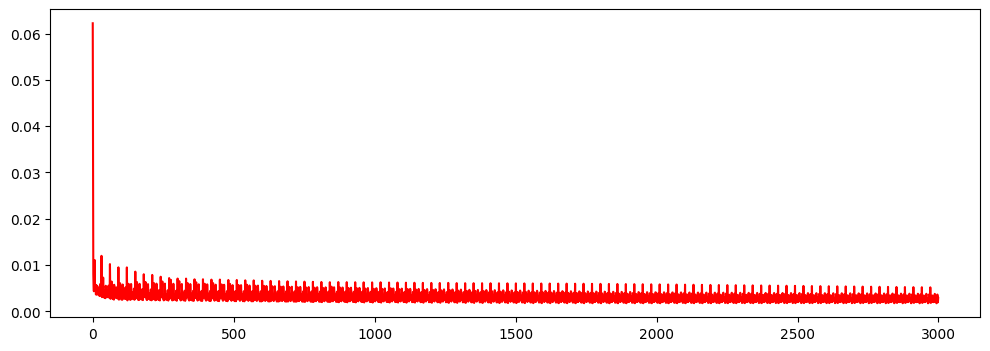

In [3]:
fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(progress, 'r')
plt.show()
plt.close()

In [4]:
tone.utils.learning.save_pickle(model, 'models/mlp.pt')
model = tone.utils.learning.load_pickle('models/mlp.pt')

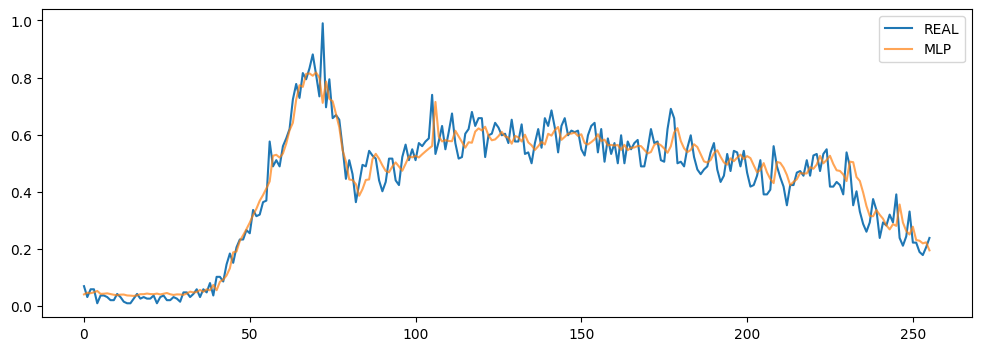

In [5]:
dataloader = torch.utils.data.DataLoader(
    dataset=utils.TrafficDataset(lags, train=False, len=500),
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    generator=torch.Generator(device=device),
)
model.eval()

real = []
pred = []
for x, t in dataloader:
    y = model.forward(x)
    real.append(t)
    pred.append(y)


real = torch.cat(real).detach().cpu()
pred = torch.cat(pred).detach().cpu()

fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(real, label='REAL')
ax.plot(pred, alpha=0.7, label=type(model).__name__)

plt.legend()
plt.show()
plt.close()

In [6]:
tone.utils.learning.metrics(real, pred)

{'mape': 0.21043098,
 'mse': 0.0032193235,
 'rmse': 0.05673908234718473,
 'mae': 0.04362582,
 'vs': 0.9329284429550171,
 'r2': 0.9326127296244896}